<a href="https://colab.research.google.com/github/Hamza1407/AnalyseTemp/blob/main/PIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import MeanAbsoluteError
from sklearn.metrics import mean_absolute_error


from tensorflow.keras.layers import Dense, Conv1D, LSTM, Lambda, Reshape,RNN, LSTMCell
import warnings
import plotly.express as px
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.layers import Conv2D, LSTM, Dense



warnings.filterwarnings('ignore')

plt.rcParams['figure.figsize'] = (10, 7.5)
plt.rcParams['axes.grid'] = False
tf.random.set_seed(42)
np.random.seed(42)


In [ ]:
df=pd.read_csv('/Enedis_M021_CDC_A083W2FL_06555426835625.csv',encoding='latin-1',sep=';')

In [ ]:
df

,Date de la mesure,Heure de la mesure,Valeur,Statut de la mesure,PRM,Type de données,Date de début,Date de fin,Grandeur métier,Grandeur physique,Statut demandé,Unité,Pas en minutes
0,21-04-2021,00:30,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,21-04-2021,01:00,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,21-04-2021,01:30,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,21-04-2021,02:00,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,21-04-2021,02:30,88,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
34987,19-04-2023,22:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34988,19-04-2023,22:30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34989,19-04-2023,23:00,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
34990,19-04-2023,23:30,0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [ ]:
df=df.drop(['Statut de la mesure','PRM','Type de données','Date de début','Date de fin','Grandeur métier','Grandeur physique','Statut demandé','Unité','Pas en minutes'],axis=1)

In [ ]:
df['Date et Heure']=df['Date de la mesure']+' '+df['Heure de la mesure']
df['Date et Heure']=pd.to_datetime(df['Date et Heure'], format='%d-%m-%Y %H:%M')


In [ ]:
df=df.drop(['Date de la mesure','Heure de la mesure'],axis=1)

In [ ]:
df

,Valeur,Date et Heure
0,88,2021-04-21 00:30:00
1,88,2021-04-21 01:00:00
2,88,2021-04-21 01:30:00
3,88,2021-04-21 02:00:00
4,88,2021-04-21 02:30:00
...,...,...
34987,0,2023-04-19 22:00:00
34988,0,2023-04-19 22:30:00
34989,0,2023-04-19 23:00:00
34990,0,2023-04-19 23:30:00


In [ ]:
df.isnull().sum()

Valeur           0
Date et Heure    0
dtype: int64

In [ ]:
df.dtypes

Valeur                    int64
Date et Heure    datetime64[ns]
dtype: object

In [ ]:
df = df.sort_values(by='Date et Heure')

In [ ]:
df

,Valeur,Date et Heure
0,88,2021-04-21 00:30:00
1,88,2021-04-21 01:00:00
2,88,2021-04-21 01:30:00
3,88,2021-04-21 02:00:00
4,88,2021-04-21 02:30:00
...,...,...
34987,0,2023-04-19 22:00:00
34988,0,2023-04-19 22:30:00
34989,0,2023-04-19 23:00:00
34990,0,2023-04-19 23:30:00


In [ ]:
fig = px.line(df, x='Date et Heure', y='Valeur', title='Évolution des valeurs en fonction de la date et de l\'heure')
fig.update_xaxes(title_text='Date et Heure')
fig.update_yaxes(title_text='Valeur')

# Affichez le graphique interactif
fig.show()

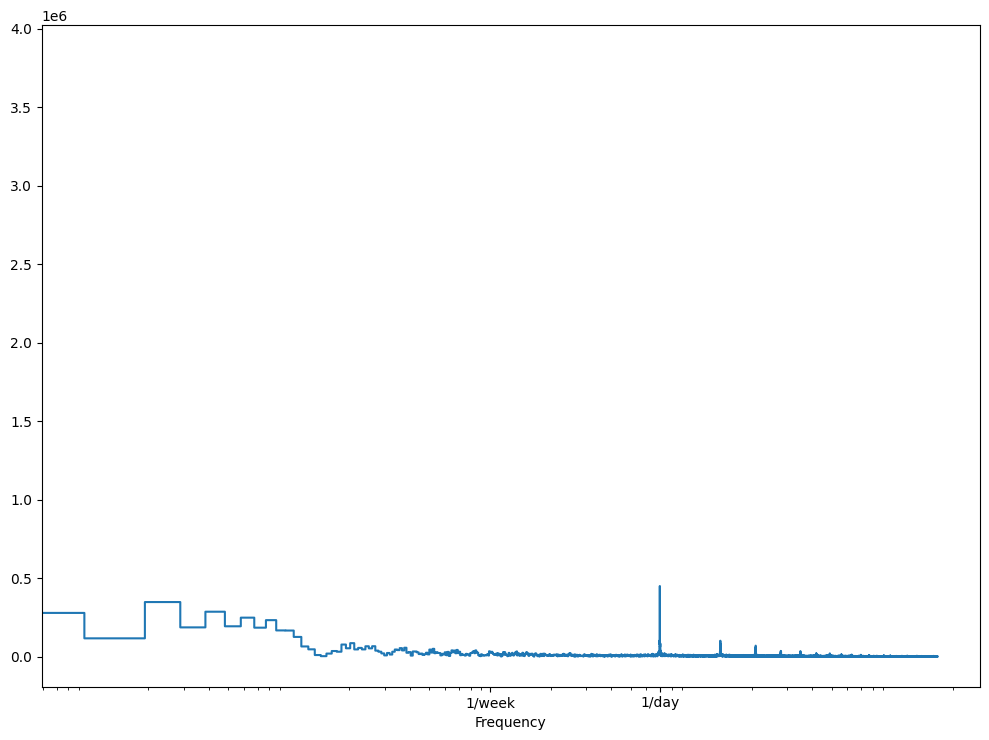

In [ ]:
fft = tf.signal.rfft(df['Valeur'])
f_per_dataset = np.arange(0, len(fft))

n_sample_h = len(df['Valeur'])/2
hours_per_week = 24 * 7
weeks_per_dataset = n_sample_h / hours_per_week
f_per_week = f_per_dataset / weeks_per_dataset

plt.step(f_per_week, np.abs(fft))
plt.xscale('log')
plt.xticks([1, 7], ['1/week', '1/day'])
plt.xlabel('Frequency')
plt.tight_layout()
plt.show()

In [ ]:
timestamp_s = pd.to_datetime(df['Date et Heure']).map(lambda x: x.timestamp())
day = 24 * 60 * 60

df['day_sin'] = (np.sin(timestamp_s * (2*np.pi/day))).values
df['day_cos'] = (np.cos(timestamp_s * (2*np.pi/day))).values
df = df.drop(['Date et Heure'], axis=1)

In [ ]:
n = len(df)
# Split 70:20:10 (train:validation:test)
train_df = df[0:int(n*0.7)]
val_df = df[int(n*0.7):int(n*0.9)]
test_df = df[int(n*0.9):]

In [ ]:
scaler = MinMaxScaler()
scaler.fit(train_df)

MinMaxScaler()

In [ ]:
train_df[train_df.columns] = scaler.transform(train_df[train_df.columns])
val_df[val_df.columns] = scaler.transform(val_df[val_df.columns])
test_df[test_df.columns] = scaler.transform(test_df[test_df.columns])

In [ ]:
column_indices = {name: i for i, name in enumerate(train_df.columns)}

In [ ]:
class DataWindow():
    def __init__(self, input_width, label_width, shift,
                 train_df=train_df, val_df=val_df, test_df=test_df,
                 label_columns=None):

        self.train_df = train_df
        self.val_df = val_df
        self.test_df = test_df

        self.label_columns = label_columns
        if label_columns is not None:
            self.label_columns_indices = {name: i for i, name in enumerate(label_columns)}
        self.column_indices = {name: i for i, name in enumerate(train_df.columns)}

        self.input_width = input_width
        self.label_width = label_width
        self.shift = shift

        self.total_window_size = input_width + shift

        self.input_slice = slice(0, input_width)
        self.input_indices = np.arange(self.total_window_size)[self.input_slice]

        self.label_start = self.total_window_size - self.label_width
        self.labels_slice = slice(self.label_start, None)
        self.label_indices = np.arange(self.total_window_size)[self.labels_slice]

    def split_to_inputs_labels(self, features):
        inputs = features[:, self.input_slice, :]
        labels = features[:, self.labels_slice, :]
        if self.label_columns is not None:
            labels = tf.stack(
                [labels[:,:,self.column_indices[name]] for name in self.label_columns],
                axis=-1
            )
        inputs.set_shape([None, self.input_width, None])
        labels.set_shape([None, self.label_width, None])

        return inputs, labels

    def plot(self, model=None, plot_col='Valeur', max_subplots=3):
        inputs, labels = self.sample_batch

        plt.figure(figsize=(12, 8))
        plot_col_index = self.column_indices[plot_col]
        max_n = min(max_subplots, len(inputs))

        for n in range(max_n):
            plt.subplot(3, 1, n+1)
            plt.ylabel(f'{plot_col} [scaled]')
            plt.plot(self.input_indices, inputs[n, :, plot_col_index],
                     label='Inputs', marker='.', zorder=-10)

            if self.label_columns:
              label_col_index = self.label_columns_indices.get(plot_col, None)
            else:
              label_col_index = plot_col_index

            if label_col_index is None:
              continue

            plt.scatter(self.label_indices, labels[n, :, label_col_index],
                        edgecolors='k', marker='s', label='Labels', c='green', s=64)
            if model is not None:
              predictions = model(inputs)
              plt.scatter(self.label_indices, predictions[n, :, label_col_index],
                          marker='X', edgecolors='k', label='Predictions',
                          c='red', s=64)

            if n == 0:
              plt.legend()

        plt.xlabel('Time (h)')

    def make_dataset(self, data):
        data = np.array(data, dtype=np.float32)
        ds = tf.keras.preprocessing.timeseries_dataset_from_array(
            data=data,
            targets=None,
            sequence_length=self.total_window_size,
            sequence_stride=1,
            shuffle=True,
            batch_size=32
        )

        ds = ds.map(self.split_to_inputs_labels)
        return ds

    @property
    def train(self):
        return self.make_dataset(self.train_df)

    @property
    def val(self):
        return self.make_dataset(self.val_df)

    @property
    def test(self):
        return self.make_dataset(self.test_df)

    @property
    def sample_batch(self):
        result = getattr(self, '_sample_batch', None)
        if result is None:
            result = next(iter(self.train))
            self._sample_batch = result
        return result

In [ ]:
def compile_and_fit(model, window, patience=3, max_epochs=50):
    early_stopping = EarlyStopping(monitor='val_loss',
                                   patience=patience,
                                   mode='min')

    model.compile(loss=MeanSquaredError(),
                  optimizer=Adam(),
                  metrics=[MeanAbsoluteError()])

    history = model.fit(window.train,
                       epochs=max_epochs,
                       validation_data=window.val,
                       callbacks=[early_stopping])

    return history

In [ ]:
multi_window = DataWindow(input_width=120, label_width=120, shift=120,label_columns=['Valeur'])

In [ ]:
class MultiStepLastBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        if self.label_index is None:
            return tf.tile(inputs[:, -1:, :], [1, 120, 1])
        return tf.tile(inputs[:, -1:, self.label_index:], [1, 120, 1])


In [ ]:
baseline_last = MultiStepLastBaseline(label_index=column_indices['Valeur'])

baseline_last.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance = {}
performance = {}

val_performance['Baseline - Last'] = baseline_last.evaluate(multi_window.val)
performance['Baseline - Last'] = baseline_last.evaluate(multi_window.test, verbose=0)

212/212 [==============================] - 1s 4ms/step - loss: 0.2124 - mean_absolute_error: 0.3129


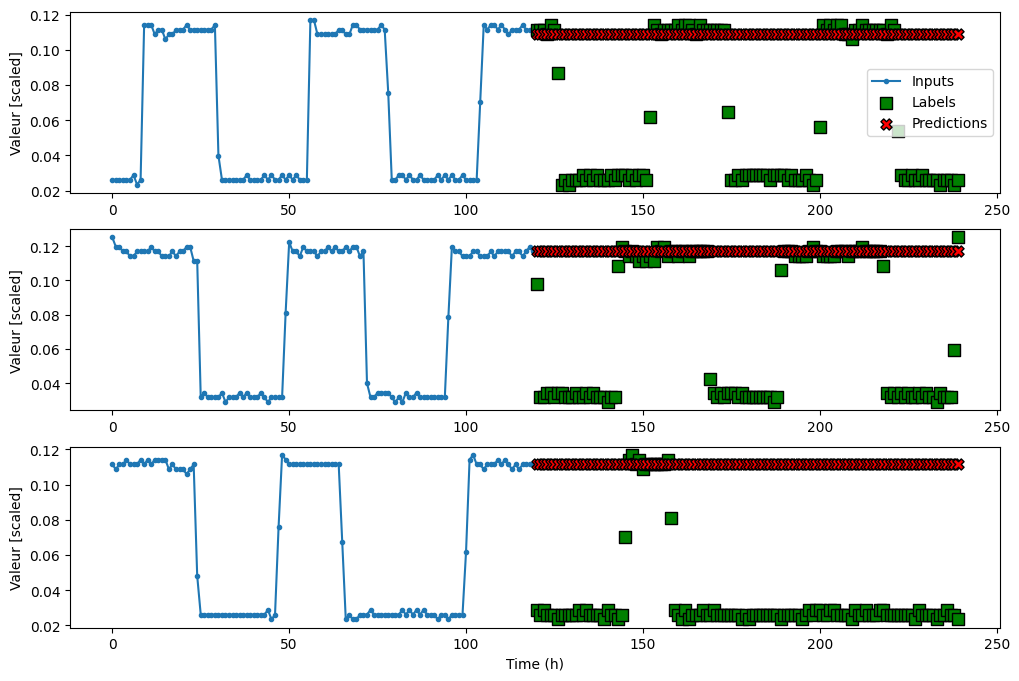

In [ ]:
multi_window.plot(baseline_last)

In [ ]:
class RepeatBaseline(Model):
    def __init__(self, label_index=None):
        super().__init__()
        self.label_index = label_index

    def call(self, inputs):
        return inputs[:, :, self.label_index:]

In [ ]:
baseline_repeat = RepeatBaseline(label_index=column_indices['Valeur'])

baseline_repeat.compile(loss=MeanSquaredError(), metrics=[MeanAbsoluteError()])

val_performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.val)
performance['Baseline - Repeat'] = baseline_repeat.evaluate(multi_window.test, verbose=0)

212/212 [==============================] - 1s 4ms/step - loss: 0.2069 - mean_absolute_error: 0.3128


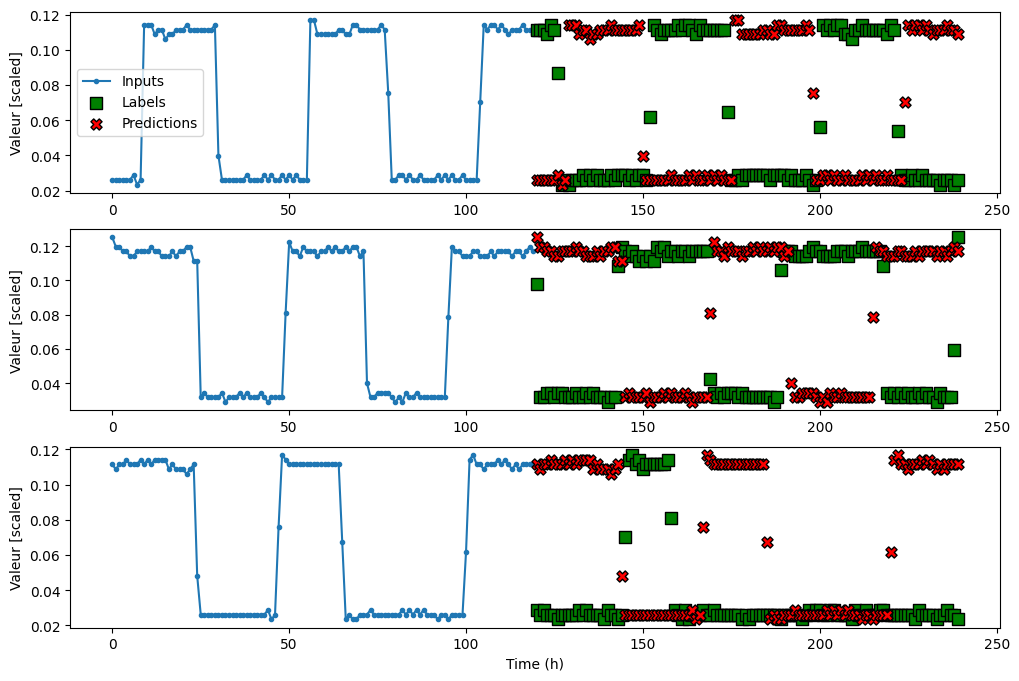

In [ ]:
multi_window.plot(baseline_repeat)

In [ ]:
label_index = column_indices['Valeur']
num_features = train_df.shape[1]

linear = Sequential([
    Dense(1, kernel_initializer=tf.initializers.zeros)
])

history = compile_and_fit(linear, multi_window)

val_performance['Linear'] = linear.evaluate(multi_window.val)
performance['Linear'] = linear.evaluate(multi_window.test, verbose=0)

Epoch 1/50
758/758 [==============================] - 5s 5ms/step - loss: 0.0013 - mean_absolute_error: 0.0258 - val_loss: 0.0018 - val_mean_absolute_error: 0.0313
Epoch 2/50
758/758 [==============================] - 5s 6ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - val_loss: 0.0019 - val_mean_absolute_error: 0.0313
Epoch 3/50
758/758 [==============================] - 3s 4ms/step - loss: 0.0012 - mean_absolute_error: 0.0240 - val_loss: 0.0019 - val_mean_absolute_error: 0.0314
Epoch 4/50
212/212 [==============================] - 1s 3ms/step - loss: 0.0019 - mean_absolute_error: 0.0314


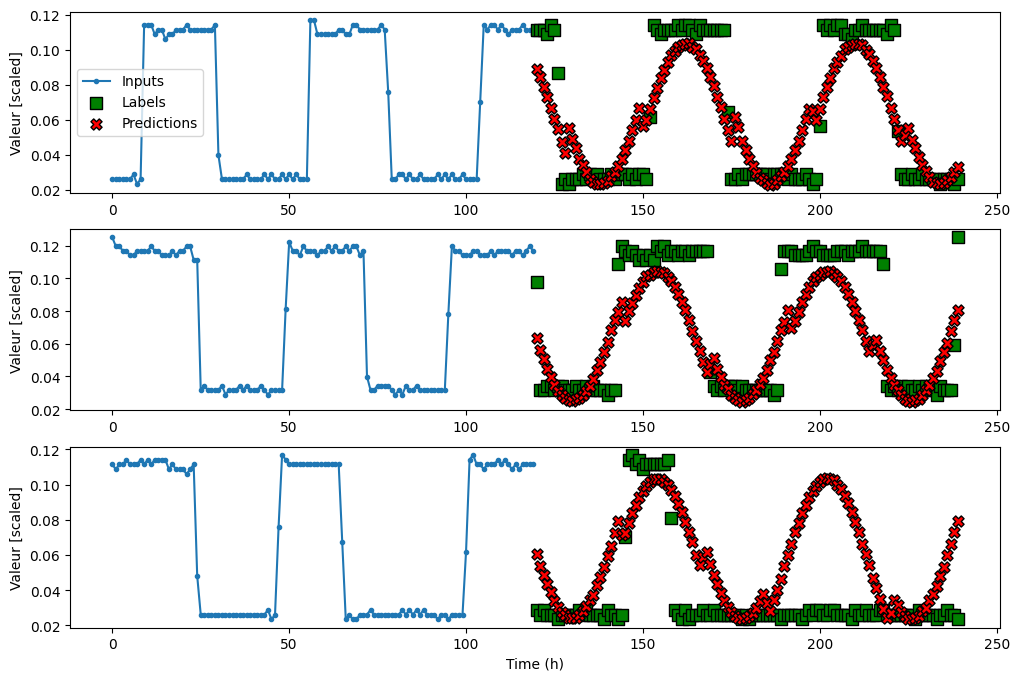

In [ ]:
multi_window.plot(linear)


In [ ]:
dense = Sequential([
    Dense(64, activation='relu'),
    Dense(64, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(dense, multi_window)

val_performance['Dense'] = dense.evaluate(multi_window.val)
performance['Dense'] = dense.evaluate(multi_window.test, verbose=0)

Epoch 1/50
758/758 [==============================] - 10s 12ms/step - loss: 0.0012 - mean_absolute_error: 0.0227 - val_loss: 0.0019 - val_mean_absolute_error: 0.0301
Epoch 2/50
758/758 [==============================] - 8s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0211 - val_loss: 0.0020 - val_mean_absolute_error: 0.0296
Epoch 3/50
758/758 [==============================] - 9s 11ms/step - loss: 0.0011 - mean_absolute_error: 0.0206 - val_loss: 0.0020 - val_mean_absolute_error: 0.0299
Epoch 4/50
212/212 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0303


In [ ]:
lstm_model = Sequential([
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(lstm_model, multi_window)

val_performance['LSTM'] = lstm_model.evaluate(multi_window.val)
performance['LSTM'] = lstm_model.evaluate(multi_window.test, verbose=0)

Epoch 1/50
758/758 [==============================] - 44s 53ms/step - loss: 0.0011 - mean_absolute_error: 0.0217 - val_loss: 0.0019 - val_mean_absolute_error: 0.0298
Epoch 2/50
758/758 [==============================] - 41s 54ms/step - loss: 8.6859e-04 - mean_absolute_error: 0.0170 - val_loss: 0.0019 - val_mean_absolute_error: 0.0289
Epoch 3/50
758/758 [==============================] - 43s 57ms/step - loss: 8.2786e-04 - mean_absolute_error: 0.0161 - val_loss: 0.0019 - val_mean_absolute_error: 0.0280
Epoch 4/50
758/758 [==============================] - 43s 56ms/step - loss: 8.1581e-04 - mean_absolute_error: 0.0159 - val_loss: 0.0019 - val_mean_absolute_error: 0.0283
Epoch 5/50
758/758 [==============================] - 43s 56ms/step - loss: 8.0136e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0020 - val_mean_absolute_error: 0.0283
Epoch 6/50
212/212 [==============================] - 3s 15ms/step - loss: 0.0020 - mean_absolute_error: 0.0285


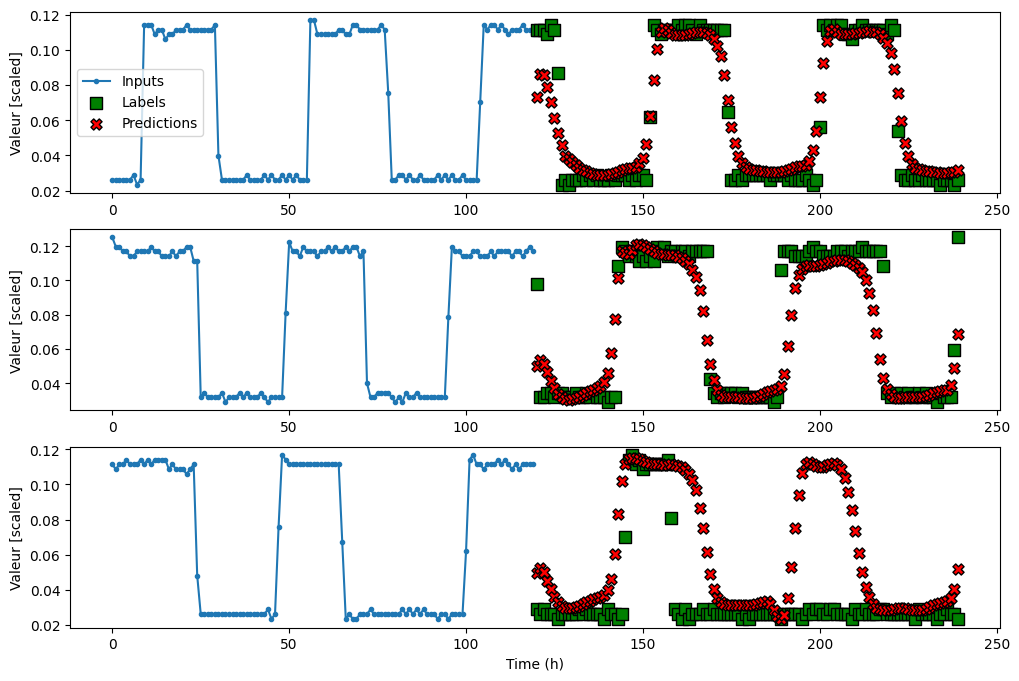

In [ ]:
multi_window.plot(lstm_model)

In [ ]:
KERNEL_WIDTH = 3
LABEL_WIDTH = 120
INPUT_WIDTH = LABEL_WIDTH + KERNEL_WIDTH - 1

cnn_multi_window = DataWindow(input_width=INPUT_WIDTH, label_width=LABEL_WIDTH, shift=120, label_columns=['Valeur'])


In [ ]:
cnn_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    Dense(units=32, activation='relu'),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_model, cnn_multi_window)

val_performance['CNN'] = cnn_model.evaluate(cnn_multi_window.val)
performance['CNN'] = cnn_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
758/758 [==============================] - 9s 11ms/step - loss: 0.0012 - mean_absolute_error: 0.0226 - val_loss: 0.0019 - val_mean_absolute_error: 0.0309
Epoch 2/50
758/758 [==============================] - 7s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0210 - val_loss: 0.0020 - val_mean_absolute_error: 0.0309
Epoch 3/50
758/758 [==============================] - 8s 10ms/step - loss: 0.0011 - mean_absolute_error: 0.0204 - val_loss: 0.0020 - val_mean_absolute_error: 0.0314
Epoch 4/50
212/212 [==============================] - 1s 5ms/step - loss: 0.0022 - mean_absolute_error: 0.0309


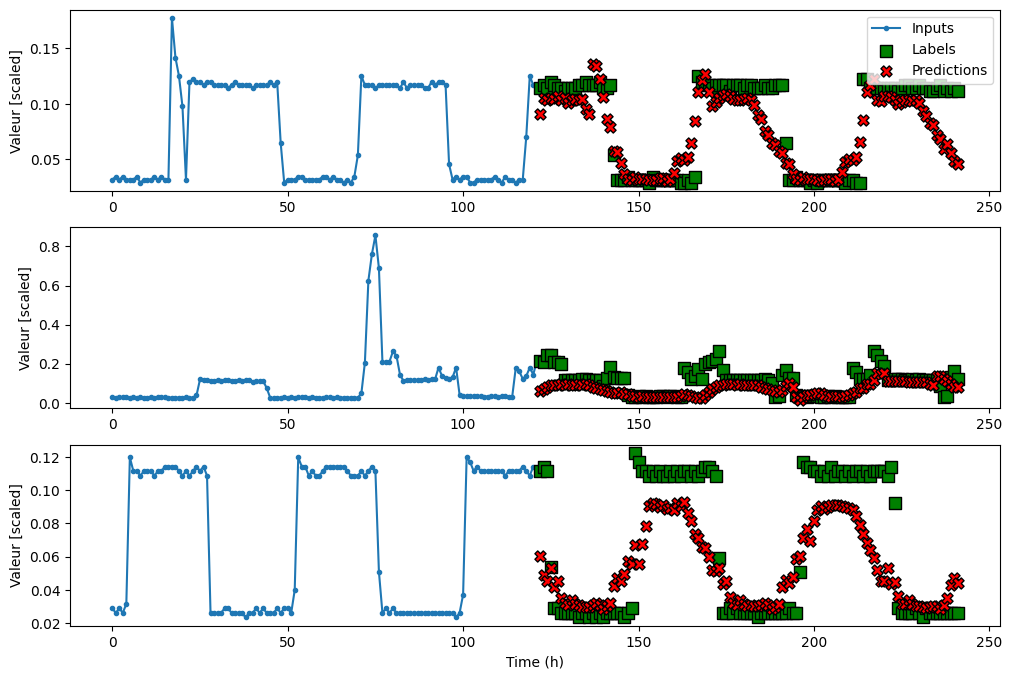

In [ ]:
cnn_multi_window.plot(cnn_model)

In [ ]:
cnn_lstm_model = Sequential([
    Conv1D(32, activation='relu', kernel_size=(KERNEL_WIDTH)),
    LSTM(32, return_sequences=True),
    Dense(1, kernel_initializer=tf.initializers.zeros),
])

history = compile_and_fit(cnn_lstm_model, cnn_multi_window)

val_performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.val)
performance['CNN + LSTM'] = cnn_lstm_model.evaluate(cnn_multi_window.test, verbose=0)

Epoch 1/50
758/758 [==============================] - 52s 65ms/step - loss: 0.0010 - mean_absolute_error: 0.0204 - val_loss: 0.0019 - val_mean_absolute_error: 0.0295
Epoch 2/50
758/758 [==============================] - 47s 62ms/step - loss: 8.2852e-04 - mean_absolute_error: 0.0163 - val_loss: 0.0018 - val_mean_absolute_error: 0.0279
Epoch 3/50
758/758 [==============================] - 48s 64ms/step - loss: 7.9812e-04 - mean_absolute_error: 0.0157 - val_loss: 0.0020 - val_mean_absolute_error: 0.0284
Epoch 4/50
758/758 [==============================] - 51s 67ms/step - loss: 7.8050e-04 - mean_absolute_error: 0.0153 - val_loss: 0.0021 - val_mean_absolute_error: 0.0286
Epoch 5/50
212/212 [==============================] - 4s 16ms/step - loss: 0.0021 - mean_absolute_error: 0.0284


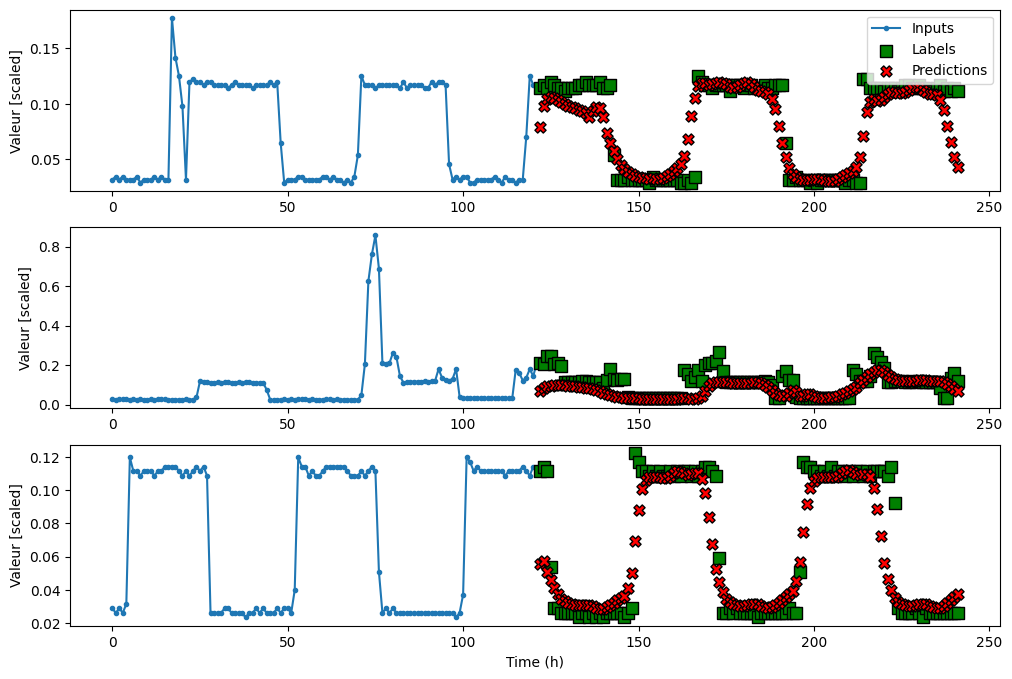

In [ ]:
cnn_multi_window.plot(cnn_lstm_model)

In [ ]:
class AutoRegressive(Model):
    def __init__(self, units, out_steps):
        super().__init__()
        self.out_steps = out_steps
        self.units = units
        self.lstm_cell = LSTMCell(units)
        self.lstm_rnn = RNN(self.lstm_cell, return_state=True)
        self.dense = Dense(train_df.shape[1])

    def warmup(self, inputs):
        x, *state = self.lstm_rnn(inputs)
        prediction = self.dense(x)

        return prediction, state

    def call(self, inputs, training=None):
        predictions = []
        prediction, state = self.warmup(inputs)

        predictions.append(prediction)

        for n in range(1, self.out_steps):
            x = prediction
            x, state = self.lstm_cell(x, states=state, training=training)

            prediction = self.dense(x)
            predictions.append(prediction)

        predictions = tf.stack(predictions)
        predictions = tf.transpose(predictions, [1, 0, 2])

        return predictions

In [ ]:
AR_LSTM = AutoRegressive(units=32, out_steps=120)

history = compile_and_fit(AR_LSTM, multi_window)

val_performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.val)
performance['AR - LSTM'] = AR_LSTM.evaluate(multi_window.test, verbose=0)

In [ ]:
multi_window.plot(AR_LSTM)

In [ ]:
mae_val = [v[1] for v in val_performance.values()]
mae_test = [v[1] for v in performance.values()]

x = np.arange(len(performance))

fig, ax = plt.subplots()
ax.bar(x - 0.15, mae_val, width=0.25, color='black', edgecolor='black', label='Validation')
ax.bar(x + 0.15, mae_test, width=0.25, color='white', edgecolor='black', hatch='/', label='Test')
ax.set_ylabel('Mean absolute error')
ax.set_xlabel('Models')

for index, value in enumerate(mae_val):
    plt.text(x=index - 0.15, y=value+0.005, s=str(round(value, 3)), ha='center')

for index, value in enumerate(mae_test):
    plt.text(x=index + 0.15, y=value+0.0025, s=str(round(value, 3)), ha='center')

plt.ylim(0, 0.33)
plt.xticks(ticks=x, labels=performance.keys())
plt.legend(loc='best')
plt.tight_layout()

